# **[CMPE 295B] Using Convolutional Neural Network for Material Classification**
# **CNN-Softmax**
# Class 1: {'FDM_FFF': 0, 'SLM_DMLS': 1}

# Install/check Tensorflow 2.0

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install --upgrade pip

     |████████████████████████████████| 1.6MB 3.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
pip install gast==0.3.3

In [3]:
!pip install -q tensorflow-gpu==2.4.1  #(optional, the default tensorflow1.15 (The final version of TensorFlow 1.x.) is installed, you can upgrade to tensorflow2.0)
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

     |████████████████████████████████| 394.3 MB 12 kB/s 
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow Version:  2.4.1
Keras Version:  2.4.0


# Load Data

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import tempfile
import shutil

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

import random
from scipy import ndarray
import math

# image processing library
import skimage as ski
from skimage import transform
from skimage import util
from skimage import io

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pip install patool

     |████████████████████████████████| 77 kB 2.4 MB/s 


In [7]:
import patoolib
#unzip files from shared google drive
zip_file_path = "/content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_1st_labels_REDO_500.zip"
patoolib.extract_archive(zip_file_path, outdir='_Images')

patool: Extracting /content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_1st_labels_REDO_500.zip ...
patool: running /usr/bin/7z x -o_Images -- "/content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_1st_labels_REDO_500.zip"
patool: ... /content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_1st_labels_REDO_500.zip extracted to `_Images'.


'_Images'

In [8]:
base_dir = "/content/_Images/content/_Images_split"

# Define train, valiation and test dataset

In [9]:
# Define batch size
BATCH_SIZE = 64

In [10]:
# Define image size for training
# image dimensions for VGG16 is 224, 224
IMAGE_SIZE = 224

# Use ImageDataGenerator to rescale the images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    )

# Create the train generator and specify where the train dataset directory, image size, batch size.
train_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    #class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

# Create the validation generator with similar approach as the train generator with the flow_from_directory() method.
val_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'val'),
    #class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

# Create the test generator with similar approach as the train generator with the flow_from_directory() method.
test_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

Found 1056 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


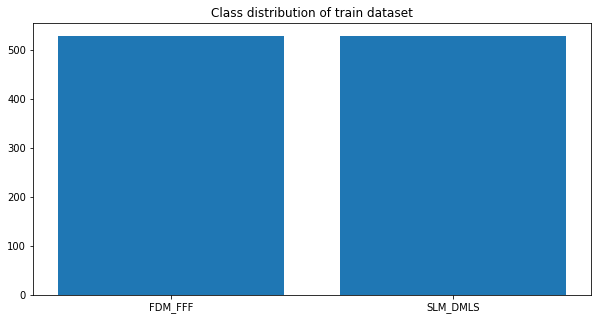

In [11]:
from collections import OrderedDict
cls_train = train_generator.classes
classes = list(train_generator.class_indices.keys())

unique, counts = np. unique(cls_train, return_counts=True)
valdict = OrderedDict(zip(unique, counts))

num_values = []
for i in range(len(train_generator.class_indices)):
  num_values.append(valdict[i])

plt.figure(figsize=(10,5))
x = np.arange(len(num_values))
xlable = classes
plt.bar(x, num_values)
plt.xticks(x, xlable)
plt.title('Class distribution of train dataset')
plt.show()

# Model : Design CNN Model with Transfer Learning

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [13]:
# Define image shape
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Define metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'), #BinaryAccuracy(name='accuracy')
      tf.keras.metrics.Precision(name='pre'),
      tf.keras.metrics.Recall(name='rec'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'auc', 'prc']
  plt.figure(figsize=(20, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0.5,1])

    plt.legend()

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

In [15]:
EPOCHS = 300

#### 1) Model Creation

In [ ]:
def make_tfmodel_modi(lr, metrics=METRICS, output_bias=None):
  # base model output shape
  vgg16 = tf.keras.applications.VGG16(
      input_shape=IMG_SHAPE,
      pooling='avg',
      include_top=False,
      weights='imagenet')
  
  layer_name = 'block5_pool'
  base_model = Model(inputs=vgg16.input, outputs=vgg16.get_layer(layer_name).output)
  
  model = Sequential([base_model,
                      #Conv2D(1024, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      #Conv2D(128, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      Conv2D(512, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      #Conv2D(128, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Flatten(), 
                      GlobalAveragePooling2D(),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      Dense(train_generator.num_classes, activation='softmax')
                      ])
  # frozen learnable parameters from VGG16
  model.layers[0].trainable = False

  model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy',
                metrics=metrics)

  return model

In [ ]:
model_vgg16_modi = make_tfmodel_modi(lr=1e-4)
model_vgg16_modi.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 512)         2359808   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

#### 2) Model Training

In [ ]:
history = model_vgg16_modi.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/300
17/17 [==============================] - 24s 1s/step - loss: 0.6854 - tp: 444.0556 - fp: 279.5000 - tn: 444.0556 - fn: 279.5000 - accuracy: 0.6142 - pre: 0.6142 - rec: 0.6142 - auc: 0.6896 - prc: 0.7036 - val_loss: 0.6088 - val_tp: 155.0000 - val_fp: 53.0000 - val_tn: 155.0000 - val_fn: 53.0000 - val_accuracy: 0.7452 - val_pre: 0.7452 - val_rec: 0.7452 - val_auc: 0.8206 - val_prc: 0.8052
Epoch 2/300
17/17 [==============================] - 21s 1s/step - loss: 0.6154 - tp: 401.8889 - fp: 183.0000 - tn: 401.8889 - fn: 183.0000 - accuracy: 0.6716 - pre: 0.6716 - rec: 0.6716 - auc: 0.7448 - prc: 0.7447 - val_loss: 0.5303 - val_tp: 168.0000 - val_fp: 40.0000 - val_tn: 168.0000 - val_fn: 40.0000 - val_accuracy: 0.8077 - val_pre: 0.8077 - val_rec: 0.8077 - val_auc: 0.8643 - val_prc: 0.8565
Epoch 3/300
17/17 [==============================] - 21s 1s/step - loss: 0.5449 - tp: 454.9444 - fp: 142.3889 - tn: 454.9444 - fn: 142.3889 - accuracy: 0.7683 - pre: 0.7683 - rec: 0.7683 - auc: 

#### 3) Model Evaluation

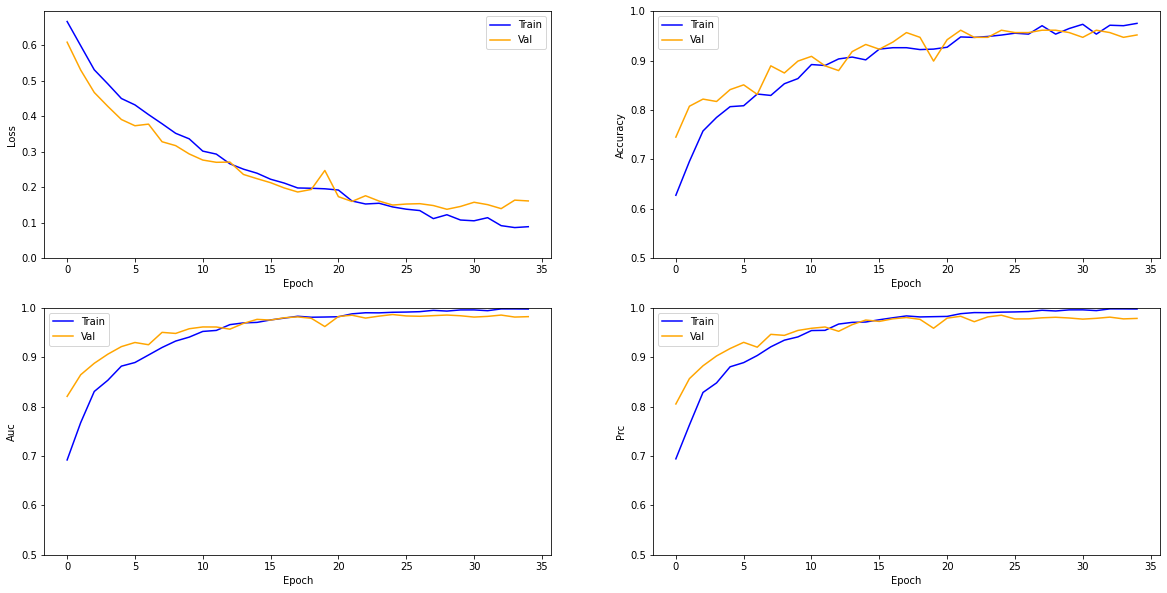

In [ ]:
plot_metrics(history)

In [ ]:
train_predictions_model = model_vgg16_modi.predict(train_generator)#, batch_size=BATCH_SIZE)
test_predictions_model = model_vgg16_modi.predict(test_generator)#, batch_size=BATCH_SIZE)

In [ ]:
print("Model results for Training dataset\n")

train_model_results = model_vgg16_modi.evaluate(train_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, train_model_results):
  print(name, ': ', value)

Model results for Training dataset

loss :  0.1242813766002655
tp :  1014.0
fp :  42.0
tn :  1014.0
fn :  42.0
accuracy :  0.9602272510528564
pre :  0.9602272510528564
rec :  0.9602272510528564
auc :  0.9940939545631409
prc :  0.9942715167999268


In [ ]:
print("Model results for Validation dataset\n")

val_model_results = model_vgg16_modi.evaluate(val_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, val_model_results):
  print(name, ': ', value)

Model results for Validation dataset

loss :  0.14996975660324097
tp :  200.0
fp :  8.0
tn :  200.0
fn :  8.0
accuracy :  0.9615384340286255
pre :  0.9615384340286255
rec :  0.9615384340286255
auc :  0.9862010478973389
prc :  0.9848001003265381


In [ ]:
print("Model results for Test dataset\n")

test_model_results = model_vgg16_modi.evaluate(test_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, test_model_results):
  print(name, ': ', value)

Model results for Test dataset

loss :  0.30942651629447937
tp :  154.0
fp :  16.0
tn :  154.0
fn :  16.0
accuracy :  0.9058823585510254
pre :  0.9058823585510254
rec :  0.9058823585510254
auc :  0.9461592435836792
prc :  0.937982439994812


In [ ]:
model_vgg16_modi.save('/content/model_vgg16_modi_1st_class.h5')



```
# This is formatted as code
```

# Model: CNN Model with SVM

# Model Creation

In [16]:
from tensorflow.keras.regularizers import l2 # this is needed for SVM

In [17]:
def make_tfmodel_modi(lr, metrics=METRICS, output_bias=None):
  # base model output shape
  vgg16 = tf.keras.applications.VGG16(
      input_shape=IMG_SHAPE,
      pooling='avg',
      include_top=False,
      weights='imagenet')
  
  layer_name = 'block5_pool'
  base_model = Model(inputs=vgg16.input, outputs=vgg16.get_layer(layer_name).output)
  
  model_svm = Sequential([base_model,
                      #Conv2D(1024, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      #Conv2D(128, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      Conv2D(512, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Dropout(0.05),
                      #Conv2D(128, (3,3), activation='relu', padding='same'),
                      #MaxPooling2D((2,2), padding='same'),
                      #Flatten(), 
                      GlobalAveragePooling2D(),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      ])

  # adding SVM layer at output
  model_svm.add(Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model_svm.add(Activation('linear')) # for multiclassification change activation to softmax
                                      # for Binary change activation to linear
  model_svm.layers[0].trainable = False

  model_svm.compile(loss='hinge',     # for multiclassification change loss to squared_hinge
              optimizer='adam',
              metrics=['accuracy'])

  #model_svm.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
  #           ='linear'))
  #when l2 regularizer IS ADDED, IT ENABLES SVM
  # frozen learnable parameters from VGG16
  #model_svm.layers[0].trainable = False

  #model_svm.compile(optimizer=Adam(lr=lr),
  #              loss='categorical_crossentropy',
  #              metrics='accuracy')

# For SVM compile loss is to be changed to hinge.
  #model_svm.compile(optimizer='adam',
  #              loss='hinge',
  #              metrics=['accuracy'])

  return model_svm

In [18]:
model_vgg16_modi = make_tfmodel_modi(lr=1e-4)
model_vgg16_modi.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 512)         2359808   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________

In [19]:
history = model_vgg16_modi.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/300
17/17 [==============================] - 61s 2s/step - loss: 0.9882 - accuracy: 0.5685 - val_loss: 0.6952 - val_accuracy: 0.7837
Epoch 2/300
17/17 [==============================] - 21s 1s/step - loss: 0.7009 - accuracy: 0.7504 - val_loss: 0.4666 - val_accuracy: 0.8173
Epoch 3/300
17/17 [==============================] - 21s 1s/step - loss: 0.5365 - accuracy: 0.7913 - val_loss: 0.3531 - val_accuracy: 0.8510
Epoch 4/300
17/17 [==============================] - 22s 1s/step - loss: 0.4121 - accuracy: 0.8385 - val_loss: 0.6392 - val_accuracy: 0.7212
Epoch 5/300
17/17 [==============================] - 22s 1s/step - loss: 0.6525 - accuracy: 0.7310 - val_loss: 0.3184 - val_accuracy: 0.8750
Epoch 6/300
17/17 [==============================] - 21s 1s/step - loss: 0.3656 - accuracy: 0.8510 - val_loss: 0.3403 - val_accuracy: 0.8462
Epoch 7/300
17/17 [==============================] - 21s 1s/step - loss: 0.3311 - accuracy: 0.8653 - val_loss: 0.2722 - val_accuracy: 0.8846
Epoch 8/300
1

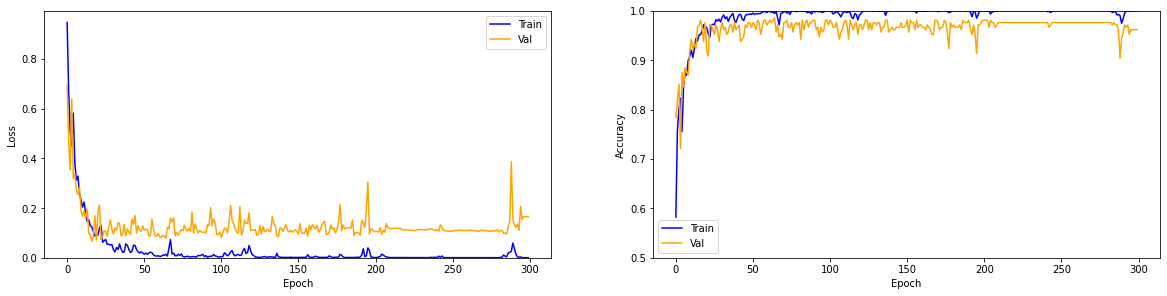

In [20]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  plt.figure(figsize=(20, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0.5,1])

    plt.legend()
plot_metrics(history)

In [21]:
train_predictions_model = model_vgg16_modi.predict(train_generator)#, batch_size=BATCH_SIZE)
test_predictions_model = model_vgg16_modi.predict(test_generator)#, batch_size=BATCH_SIZE)

In [22]:
print("Model results for Training dataset\n")

train_model_results = model_vgg16_modi.evaluate(train_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, train_model_results):
  print(name, ': ', value)

Model results for Training dataset

loss :  0.00046153555740602314
accuracy :  1.0


In [23]:
print("Model results for Validation dataset\n")

val_model_results = model_vgg16_modi.evaluate(val_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, val_model_results):
  print(name, ': ', value)

Model results for Validation dataset

loss :  0.16466590762138367
accuracy :  0.9615384340286255


In [24]:
print("Model results for Test dataset\n")

test_model_results = model_vgg16_modi.evaluate(test_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, test_model_results):
  print(name, ': ', value)

Model results for Test dataset

loss :  0.46040257811546326
accuracy :  0.8941176533699036


In [25]:
model_vgg16_modi.save('/content/model_vgg16_modi_1st_class.h5')